In [2]:
import pandas as pd 
import numpy as np 
import re 
import sys

In [3]:
itTicketDF=pd.read_excel('IT-Ticket-Classification.xlsx')
itTicketDF.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [4]:
callers = itTicketDF['Caller'].unique() 
display(callers.shape)
itTicketDF.drop(["Caller",'Short description'],axis=1,inplace= True)
itTicketDF.info()

(2950,)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8499 non-null   object
 1   Assignment group  8500 non-null   object
dtypes: object(2)
memory usage: 132.9+ KB


In [5]:
targetClassCnt=itTicketDF['Assignment group'].value_counts()
targetClassCnt.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

In [6]:
sample = itTicketDF.groupby(['Assignment group'])
regroup=[]
for grp in itTicketDF['Assignment group'].unique():
    if(sample.get_group(grp).shape[0]<10):
        regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
itTicketDF['Assignment group']=itTicketDF['Assignment group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
itTicketDF['Assignment group'].unique()

Found 25 groups which have under 10 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'misc_grp', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

<ipython-input-7-ca72a9c3bdac>:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


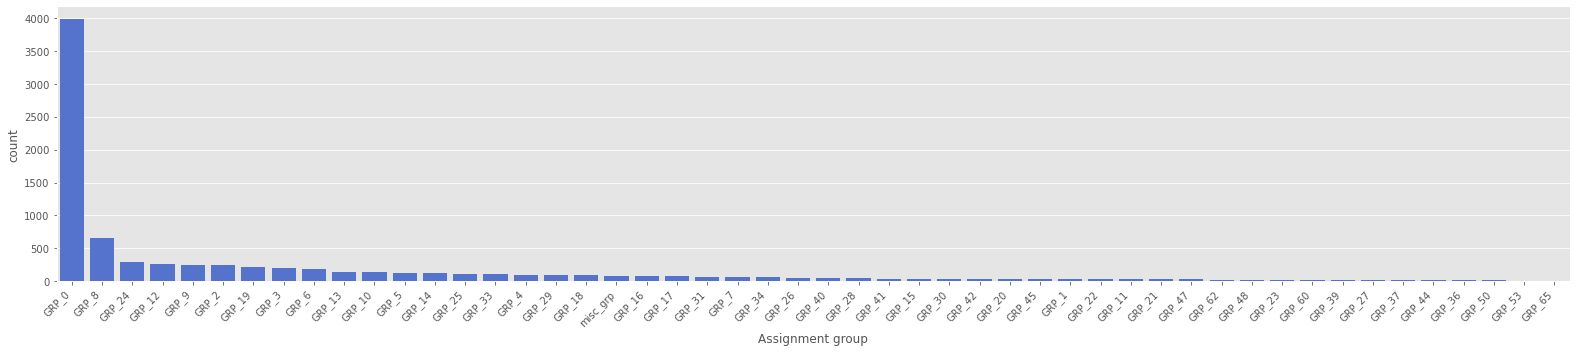

In [7]:
##Pre-Processing label Encoding on  Assignment Group
import seaborn as sns
import matplotlib.pyplot as plt
#add to remove warning for python 3.6 dependency
import warnings
import pandas.util.testing as tm
plt.style.use('ggplot')
%matplotlib inline

descending_order = itTicketDF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#added code for x label rotate 
ax=sns.countplot(x='Assignment group', data=itTicketDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [8]:

#Fill 'Decsription' field entries that have null with blank space
itTicketDF['Description'].fillna(value=' ', inplace=True)

In [9]:
from dateutil import parser
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

In [10]:
def clean_data(text):
    text=text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove Non Dictionary character-TODO
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    #& 
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in callers:
        namelist = [part for part in name.split()]
        for namepart in namelist: 
            text = text.replace(namepart,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [11]:
itTicketDF['Description'] = itTicketDF['Description'].apply(clean_data)

In [12]:
itTicketDF['length']=[len(text) for text in itTicketDF['Description']]
itTicketDF=itTicketDF[itTicketDF['length']>=3]
itTicketDF['Description'] = itTicketDF['Description'].apply(lambda x : " ".join([word for word in x.split() if(len(word)>2)]))



<ipython-input-12-089817d79db9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itTicketDF['Description'] = itTicketDF['Description'].apply(lambda x : " ".join([word for word in x.split() if(len(word)>2)]))


In [13]:
germanwordlist = ['bitte','nicht','konto','probleme','berechtigung','defekt','mehr','ausgetauscht','rechner', 'drucker','teilweise','freigegeben','genannten','anmeldeaccount',
                  'besprochen','werden','durchwahl','oben','einrichten','zeitwirtschaft','seit','morgens','beheben','keine','zeitbuchungen','vorhanden','dringend','fehler',
                  'werk','anmelde','auftrag','kein','skannen','freundlichen','werkzeuge,','hartstoffe','maste','schutzw','fertigung','immer','sehr','zugriff','freundliche',
                  'geehrter','souzarft','noch','verbindungsherstellung','meldung','erneuten','glich','proben','beilageproben','beilage','auswerten','sinterleitstand','reparar',
                  'reparo','rechner','koenigsee','entregar','atualiza','declara','programdntya','funcionando','preciso','hitacni','grergtger','zugriffsrechte','teamleiter',
                  'abholen','wegen','weit','absender','wenn','abrechnung']
pattern = '|'.join(germanwordlist)

pattern

'bitte|nicht|konto|probleme|berechtigung|defekt|mehr|ausgetauscht|rechner|drucker|teilweise|freigegeben|genannten|anmeldeaccount|besprochen|werden|durchwahl|oben|einrichten|zeitwirtschaft|seit|morgens|beheben|keine|zeitbuchungen|vorhanden|dringend|fehler|werk|anmelde|auftrag|kein|skannen|freundlichen|werkzeuge,|hartstoffe|maste|schutzw|fertigung|immer|sehr|zugriff|freundliche|geehrter|souzarft|noch|verbindungsherstellung|meldung|erneuten|glich|proben|beilageproben|beilage|auswerten|sinterleitstand|reparar|reparo|rechner|koenigsee|entregar|atualiza|declara|programdntya|funcionando|preciso|hitacni|grergtger|zugriffsrechte|teamleiter|abholen|wegen|weit|absender|wenn|abrechnung'

In [14]:
germanDescIndex = itTicketDF[itTicketDF['Description'].str.contains(pattern)].index
germanDescIndex

Int64Index([ 223,  238,  251,  255,  265,  270,  272,  302,  304,  305,
            ...
            8414, 8417, 8419, 8420, 8425, 8427, 8436, 8439, 8467, 8499],
           dtype='int64', length=586)

In [30]:
# since translation done by googletrans & textblob is giving error while using checking & translating every row, just checking the "Description" for german word like 'bitte'
#!pip install -q googletrans

from googletrans import Translator

def translateIfRequired(x):
    
    translator = Translator()
    
    print(translator.translate(x).text)
    
    if translator.detect(x).lang != 'en':
        print("HERE")
        
        translatedText = translator.translate(x).text
    else:
        translatedText = x
    return translatedText

In [31]:
for rowId in germanDescIndex:
    
    itTicketDF['Description'][rowId] = translateIfRequired(itTicketDF['Description'][rowId])

hello happened again, he hung himself up again and again and just sent me a blue screen with white letters, what can we do


<ipython-input-31-c0b40b93d5f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itTicketDF['Description'][rowId] = translateIfRequired(itTicketDF['Description'][rowId])
C:\python\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


all have connectivity issue between erp and msd crm due certificate renewal azure websites and that certificate not yet updated erp side issue changes data records accounts sales area data partner functions contacts leads are not being processed from erp worked with msd crm and vice versa all environments prod and dev issue start time troubleshooting steps when tryhdty from customer master team reported the issue that prospect account created erp didn come into msd yet erp team observed that the records are still awaiting acknowledgement status which basically means they are not yet delivered received the target system upon some log analysis and trying identify the root cause between erp basis and msd teams been observed that the issue has started production environment since around est observed the same behavior with azure mfg tool and erp logs other non production environments well you can find error screenshots from erp system the mail chain root cause appears that the certificate f

please unlock erp account from 
Please zerp password 
Connection between printer and eemw cannot be established 
Please open the power supply unit or power plug evhw incoming goods and repair if necessary, you can only switch on after moving the plug 
I would like to create a serial letter but cannot open my data source excellist system error please help thank you 
the following word document can no longer be edited edksm certificate customer doc the cursor jumps permanently to the page 
hello please jannek ndling access to the folder department training with best wishes 
tool sometimes doesn't work at all 
problems with outlook 
computer optiplex defective ewe 
hello please read set up write authorization is discussed with gru head of the technical services department managing director registered office germany registered office listed the court register germany personally liable partner general partner company company Beteiligungs gmbh registered office rth bay registered registered 

please reset password user franhtyuj was entered incorrectly several times thank you 
erp training room cannot connect projectors 
just tried change password via password manager and locked totally would you please kind and unlock again that can change again mit kind analyst logistics company shared services gmbh managing director this communication is solely intended for the use of the addressee and may contain information worthy of protection Confidential or exempt from disclosure under applicable law, the distribution or reproduction of this communication by people who are not the intended recipients is strictly prohibited.If you have received this communication by mistake, please notify the sender and mail you this message company posts select the following link view the disclaimer alternate language 
monitor defective for new building stock 
I can not fold my VPN 
Problems with laser 
probleme mit lasplant 
when i call outlook the computer also wants to connect to the collaboratio

problems with skype and outlook user dardabthyr 
problems with skype and outlook dardabthyr 
Please get us usb sticks with us again a broken 
our laserjet copier shows an error message: transfer unit is missing 
Telephone with the number is defective Sinternei Germany please repair 
problems with vpn 
problems with companyguest 
problems with printer local 
i need help with changing my password and switching on my microphones with skype, although i may not call other people at skype meetings 
computer evhw does not work anymore outlook 
nwfodmhc exurcwkm amar the synchronization with exchange activesync is temporarily blocked on your ger until access is granted by the administrator importance high please usa access for that company owned device user grbhybrdg thanking you anticipation oqlcdvwi pulcqkzo sent by microsoft outlook on wednesday regarding the synchronization with exchange activesync is temporarily blocked on your device until access is granted by the administrator access fr

disable private address fields new and edit buttons employee master crm
nothing can be received or sent from this address 
dear please help need approve this but cannot the following expense report has been submitted for your approval personnel expense report start date end date total costs usd reimbursement amount usd review this expense report full please log into your universal worklist manager self service get this message mit freundlichen best
support calculator measuring device 
computer does not work 
computer viotto does not work 
erp netweaver portal is no longer the same to call up the order overview under the fine navigation parameter, see attached screenshots 
computer ewewx olympus no access to hostname tool was like 
install tool and bls calculator olympus 
hello please write and read authorization user maerza on the folder staebefertigung line set up thank you 
nyifqpmv kfirxjag conversation with nyifqpmv kfirxjag hello ramdntyassthywamy sebfghkasthian asked send you the

source system name whqsm reference company com user name location dmz sms status field sales user yes dsw event log see below the ctoc has received least occurrences vid possible magento mage adminhtml block widget gridgetcsvfile sql injection attempt inbound cve alerts from your isensor device isensplant company com for traffic not blocked sourcing from port tcp dallas usa destined port tcp usa usa that occurred this indicates that the external host and possibly other sources are attempting discover your public facing servers including vulnerable the magento mage adminhtml block widget grid getcsvfile sql injection vulnerability described cve this ticket will effectively serve master ticket for any related alerts until receive feedback from you how handle these events going forward please let know either corresponding via this ticket and delegating the ticket back the ctoc calling have number options available for the handling future alerts such this one autoresolve these alerts direc

hello computer hot and the fan runs all the time you can hear mit freundlichen best
hallo der monitor von ahmet materiallager macht probleme kannst dir das bitte anschauen
terminal bei iso nnen tool keine zeichnungen mehr aufgerufen werden diese funktion wird wegen der auftragsbereitstellung ben tigt
please unlock user ghjvreicj immediately erp and extend the account immediately needed tomorrow our run von tszvorba wtldpncx mail gesendet mittwoch nkjtoxwv wqtlzvxu betreff erp gesperrt bitte dringend wieder frei schalten wichtigkeit hoch hallo herr hohgajnn ich wollte mich eben ein weiteres mal anmelden und habe auch sicher die korrekten anmeldedaten eingegeben leider bin ich nun gesperrt anbetracht der bevorstehenden abrechnung ben tige ich dringend eine freischaltung erp vielen dank voraus und viele tszvorba wtldpncx teamleitung logo neu final klein personal partner strixner gmbh diese mitteilung ist einzig und allein die nutzung durch den adressaten bestimmt und kann informationen en

kunde erh unsere rechnungen per mail rechnungsempf nger empfangende mail adresse bis zum hat der kunde problemlos die rechnungen erhalten dem nicht mehr dem kunden liegen die rechnungen somit nicht vor und werden deshalb auch nicht bezahlt ich kann keine nderung feststellen und bitte deshalb rung danke translation customer receive our inwarehouse tools email inwarehouse tool recipient receiving email address until the customer easily get the bills from not the customer therefore not before the bills and are therefore not paid can not detect any change and therefore ask for clarification
der ganz alter halbautomaten schaltet sich anscheinend hitze fter vom netzteil dreht nicht
hallo marfhtyio mit dem freischalten von srgtycha geht klar rdest bitte den bxgwyamr hjbukvcq personalnr und den personalnr ebenfalls freischalten danke voraus mfg reinhard von gesendet mittwoch betreff zugriffsrechte hallo reinhard ich bitte ein approval den zugriff gruss marfhtyio mit freundlichen ssen best
gute

folgender fehler ist bei der erstellung der zeitnachweise aufgetreten siehe anhang alle ferienarbeiter bzw randstad mitarbeiter sind nur bis einschlie lich donnerstag den system
hallo ruchitgrr hallo frau haug leider enth dieser report nur meine tsk positionen entsprechend der beschreibung sollte mein gesamtes verkaufsgebiet alle abgebildet sein gru sales manager sales germany company deutschland gmbh urspr ngliche nachricht von mail gesendet montag betreff open order schedule lines hello this report your weekly open order schedule lines report lists all scheduled delivery dates for open orders for your customers expected that you will use this report effectively manage your sales territory you have any questions with regard the report please contact your regional sales operational excellence lead how read this report all scheduled order items are listed the report the columns with the purple field names show total values for that line the order and should not added together these tota

keine verbindung zum server kein zugriff auf laufwerke germany
favor reparar pdf creator quando vou imprimir recibo gia pdf est saindo somente caracteres
hallo seit dem ich mein passwort ndert habe habe ich keinen zugriff auf die netzlaufwerke vpn funktioniert glaube ich nicht richtig danke ihre unterst tzung mit freundlichen best
hallo zusammen beim einloggen mit dem password management tool password manager wurde mir das konto erneut gesperrt bitte erneut freischalten and ein ltiges password zur anmeldung mir war nicht klar welches password ich verwenden soll mit freundlichen best
hallo danke ihre antwort ich habe gerade versucht aber funktioniert nicht ich habe versucht mit demselben benutz namen und password das ich sid benutz ich habe auch mit password daypay versucht wie vorgeschlafen hat welches passwort sollte ich benutzen distinti saluti mit freundlichen best
probleme mit vpn hrmann
probleme mit schichtplanung
wie kann ich die ste freischalten mit freundlichen kind
probleme mi

probleme mit erpgui
alte equipment abholen
monitor defekt ewew pvd bur orde
dear please create ticket update the emea vendor master file from move the ticket nahytua another available colleague only accounting view should done today very urgent
the discription shows correctly for mmaster but not for
mitarbeiter reichenberg philipp ben tigt berechtigung den ordner file leiter
drucker messmaschine halle hat ndig papierstau
guten tag the hub sst sich meinem rechner nicht ffnen der bildschirm baut sich nicht auf einige wenige male funktioniert auf anderen rechnern funktioniert browserproblem mit freundlichen analyst payroll gesch ftsf hrer
telephony software software upgrade funktioniert nicht empl vor dem start des upgrades wurden alle programdntyme geschlossen nach dem start des upgrades erschien folgende fehlermeldung wusa exe anwendungsfehler siehe datei nach der best tigung mit wurde anwendung geschlossen und der upgrade nicht durchgef hrt translation telephony software software upgra

von pradyhtueep yyufs gesendet nathyresh gayhtjula erp fico ebusaar munnangi iszaguwe bdfzamjs joacrhfz ctrbjusz maryhtutina bauuyternfeyt betreff zahllauf nicht ausgef hrt international payments rejected jartnine are looking into the development changes which were implemented recently will get back you tomorrow sorry for any inconvenience
wegen ein sicherheitsupdate sind keine netzwerkverbindung moeglich fehlermeldung keine netzwerk verbinung
kann keine auftrag gedruckt werden ziehe fehler
zlettel mit freundlichen best
error verbindung system production order interface app mit destination production order interface vendor connc fehlerhaft fehler beim ffnen einer rfc verbindung cpic call
hello path the folder hostname departments lean lean projekte lean projekte geplant file hostname departments lean lean projekte lean projekte geplant mit freundlichen best
wir haben hier koenigsee probleme mit dem druck aus erp kommt ein production order interface app fehler
wird nichts mehr ausgedruc

der drucker steht platz von
nwfodmhc exurcwkm die synchronisierung mit exchange activesync ist auf ihrem ger vor bergehend blockiert bis der zugriff vom administrator gew hrt wird importance high help team please unblock new company device
mehreren lassen sich verschiedene prgramdntyme nicht ffnen bereich cnc


In [32]:
germanDescIndex_new = itTicketDF[itTicketDF['Description'].str.contains(pattern)].index
germanDescIndex_new

Int64Index([ 238,  874,  914,  932,  995, 1233, 1572, 1576, 1737, 1772,
            ...
            8414, 8417, 8419, 8420, 8425, 8427, 8436, 8439, 8467, 8499],
           dtype='int64', length=337)

In [33]:
# combining description and short description
itTicketDF.reset_index(drop=True,inplace=True)

itTicketDF['Description'] = itTicketDF['Description'].str.strip()
itTicketDF['Description'] = itTicketDF['Description'].str.lower()

from collections import OrderedDict
itTicketDF['Description']=itTicketDF['Description'].str.split().apply(lambda x:OrderedDict.fromkeys(x).keys()).str.join(' ')
itTicketDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439 entries, 0 to 8438
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8439 non-null   object
 1   Assignment group  8439 non-null   object
 2   length            8439 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 197.9+ KB


<ipython-input-33-c28669670f5b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itTicketDF['Description'] = itTicketDF['Description'].str.strip()
<ipython-input-33-c28669670f5b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itTicketDF['Description'] = itTicketDF['Description'].str.lower()
<ipython-input-33-c28669670f5b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [44]:
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

sr = stopwords.words('english')
for i,text in enumerate(itTicketDF['Description']):
    itTicketDF['Description'][i]=" ".join(word for word in text.split(' ') if word not in sr)

# install spacy and plt for gensim  
!pip install -q spacy 
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

itTicketDF['Description'] = itTicketDF['Description'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Use Sapcy for lemmatistaion
#### Use PyLDAvis for the plot to provide good info on clustering.
#### Use NLTk explicitly (stop word removal)on each Value in text_combined .
#### Use bigram model to cluster relevant data together usings genSIM.

In [34]:
!pip install -q pyLDAvis

In [35]:

# Gensim
import gensim
import gensim.corpora as corpora
#Remove stemming(snowball stemming) add lemmatistaion using simple_process from gensim 
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this 
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [36]:
#to process the simple_process gensim package as input needed as string 
combined_text=itTicketDF.Description.values.tolist()

In [37]:
#Convert  Combined text from each sentense to the words. use of simple_process as it tokenize() internally
#https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(combined_text))

In [38]:
# Build the bigram and trigram models
#https://radimrehurek.com/gensim/models/phrases.html
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [39]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [40]:
data_words_bigrams = make_bigrams(data_words)

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [42]:
wordclouds=' '.join(map(str, data_words_bigrams))

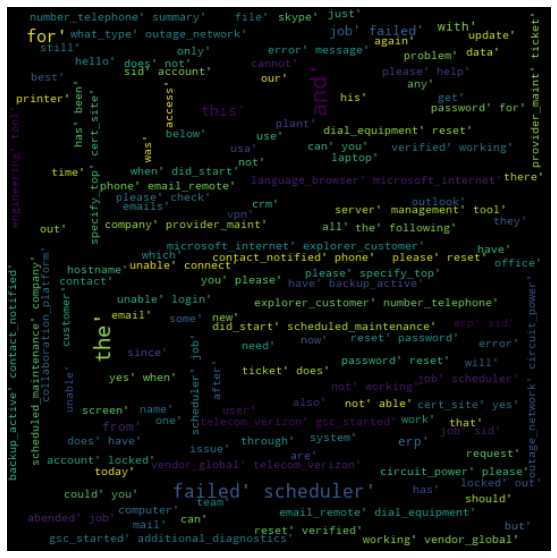

In [32]:
wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10).generate(wordclouds)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

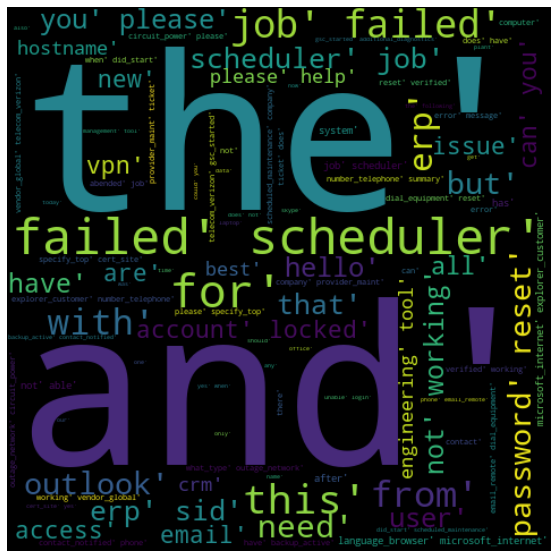

In [33]:
#check for the word count 100)
wordcloud_2 = WordCloud(width=480, height=480, max_words=100).generate(wordclouds)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [43]:
#Copying to new dataframe to create wordclouds on target class

new_df = itTicketDF.copy()
new_df['words'] = data_words_bigrams
new_df

,Description,Assignment group,length,words
0,verified user details employee and manager nam...,GRP_0,192,"[verified, user, details_employee, and, manage..."
1,hello team meetings skype etc are not appearin...,GRP_0,134,"[hello, team, meetings, skype, etc, are, not, ..."
2,cannot log vpn best,GRP_0,28,"[cannot, log, vpn, best]"
3,unable access tool page,GRP_0,29,"[unable, access, tool, page]"
4,skype error,GRP_0,11,"[skype, error]"
...,...,...,...,...
8434,good afternoon not receiving the emails that s...,GRP_29,79,"[good_afternoon, not, receiving, the, emails, ..."
8435,telephony software issue,GRP_0,24,"[telephony_software, issue]"
8436,vip windows password reset for tifpdchb pedxruyf,GRP_0,48,"[vip, windows, password, reset, for, tifpdchb,..."
8437,unable access the machine utilities finish dra...,GRP_62,99,"[unable, access, the, machine, utilities, fini..."


In [44]:
#Sorting based on frequency of target class Assignment group

value = new_df['Assignment group'].value_counts().sort_values(ascending=False).index
value

Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29', 'GRP_18', 'misc_grp', 'GRP_16', 'GRP_17',
       'GRP_7', 'GRP_31', 'GRP_34', 'GRP_26', 'GRP_40', 'GRP_28', 'GRP_41',
       'GRP_15', 'GRP_42', 'GRP_20', 'GRP_45', 'GRP_1', 'GRP_22', 'GRP_11',
       'GRP_21', 'GRP_47', 'GRP_23', 'GRP_62', 'GRP_60', 'GRP_39', 'GRP_30',
       'GRP_27', 'GRP_37', 'GRP_44', 'GRP_36', 'GRP_50', 'GRP_65', 'GRP_53',
       'GRP_48'],
      dtype='object')

In [45]:

# Creating a function for wordcloud
def wordcloud_grp(f, x):
    wordclouds_0=' '.join(map(str, f))

    wc = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, max_words=50).generate(wordclouds_0)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common 50 words of {}".format(x))
    plt.margins(x=0, y=0)
    plt.show()

In [46]:

# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus from post clean data 
texts = data_words_bigrams

# Term Document Frequency and Bag of words 
#https://radimrehurek.com/gensim/corpora/dictionary.html
corpus = [id2word.doc2bow(text) for text in texts]

In [47]:
# Build LDA model
#https://radimrehurek.com/gensim/models/ldamodel.html
lda_model = LdaModel(corpus=corpus,id2word=id2word,num_topics=7,random_state=200,update_every=1,chunksize=800,passes=10,alpha='auto',per_word_topics=True)

In [48]:
#top 7 topics from the corpus 
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"let_know" + 0.008*"company" + 0.008*"hostname" + 0.007*"per" + '
  '0.006*"ticket" + 0.006*"name" + 0.006*"com" + 0.005*"click" + '
  '0.005*"blocked" + 0.005*"summary"'),
 (1,
  '0.055*"password" + 0.054*"reset" + 0.021*"erp" + 0.020*"summary" + '
  '0.017*"name" + 0.016*"language_browser" + 0.016*"microsoft_internet" + '
  '0.016*"explorer_customer" + 0.015*"number_telephone" + 0.014*"sid"'),
 (2,
  '0.116*"job" + 0.111*"scheduler" + 0.071*"failed" + 0.049*"abended" + '
  '0.029*"sid" + 0.011*"hostname" + 0.009*"tool" + 0.007*"these" + '
  '0.007*"cold" + 0.006*"document"'),
 (3,
  '0.031*"ticket" + 0.028*"account" + 0.022*"please" + 0.022*"company" + '
  '0.021*"unlock" + 0.021*"phone" + 0.019*"working" + 0.019*"have" + '
  '0.019*"erp" + 0.018*"reset"'),
 (4,
  '0.039*"the" + 0.026*"please" + 0.025*"and" + 0.021*"not" + 0.020*"for" + '
  '0.016*"this" + 0.012*"with" + 0.012*"can" + 0.012*"you" + 0.011*"have"'),
 (5,
  '0.036*"unable" + 0.026*"user" + 0.022*"not" + 0.

In [49]:
texts=data_words_bigrams
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.437740981486186

Coherence Score:  0.5243775228098856


In [47]:
# Visualize the topics
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

In [50]:
# add a deep copy to another dataframe itTicketDF  to other DF
data =  itTicketDF.copy()
data['num_words'] = data.Description.apply(lambda x : len(x.split()))
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
length,8439.0,141.761228,312.312703,3.0,34.0,58.0,148.0,6190.0
num_words,8439.0,14.817869,21.983772,0.0,4.0,8.0,19.0,472.0


In [51]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})



Generate Dataset for createing 2 models
Model 1 : Group 0 & all other groups combined to "other"
Model 2 : Group 0 removed & only includes other groups
Model 1 will be use dto classing group 0. If not found to be Group 0, we can classify using Model 2.

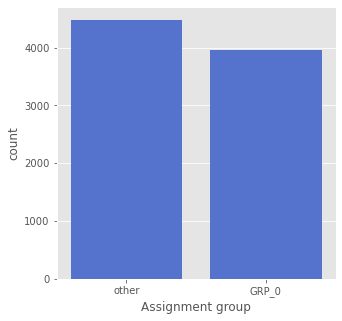

In [52]:

# Create the Dataset for classifying GRP_0
itTicketGRP0DF = itTicketDF.copy()
itTicketGRP0DF['Assignment group']=itTicketGRP0DF['Assignment group'].apply(lambda x : 'other' if x != 'GRP_0'  else x)

descending_order = itTicketGRP0DF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=itTicketGRP0DF, color='royalblue',order=descending_order)

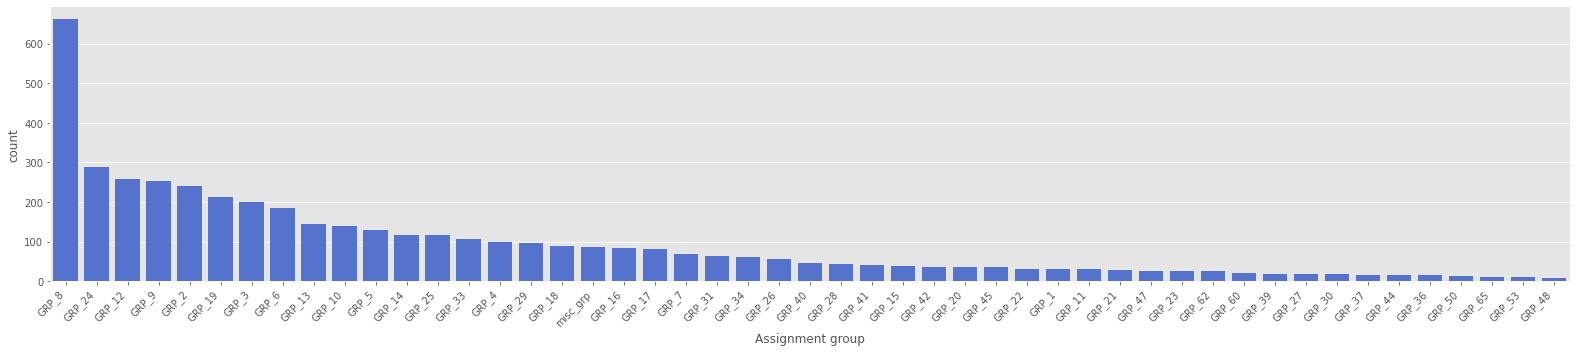

In [53]:
#Create Dataset for 'others' i.e all groups which is not part of GRP_0
itTicketOthersDF = itTicketDF[itTicketDF['Assignment group'] != 'GRP_0']

descending_order = itTicketOthersDF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketOthersDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [54]:
maxOthers = itTicketOthersDF['Assignment group'].value_counts().max()
maxOthers

661

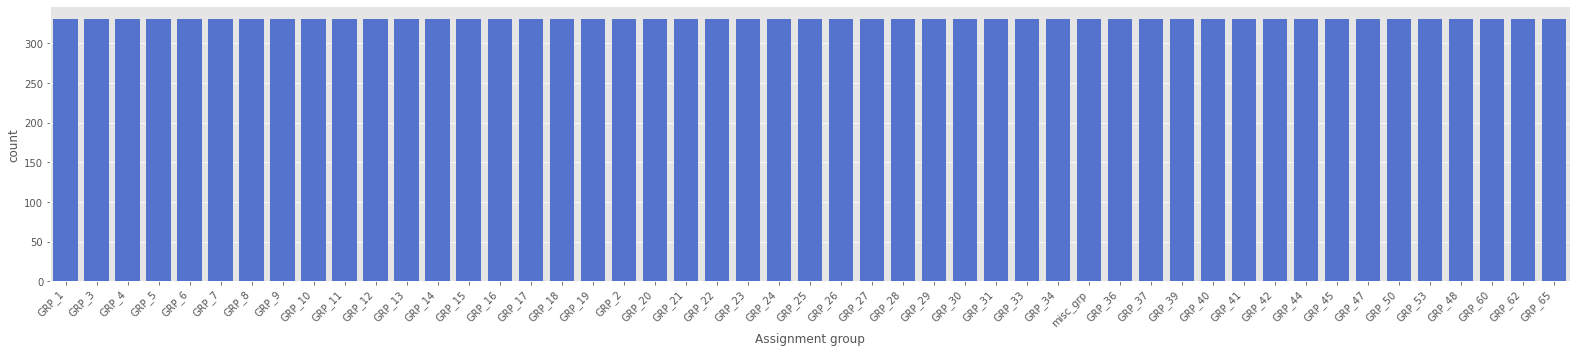

In [55]:
# Treat the imbalnce in the 'other' dataset by resampling
from sklearn.utils import resample
itTicketOthersDF_resampled = itTicketOthersDF[0:0]
for grp in itTicketOthersDF['Assignment group'].unique():
    itTicketGrpDF = itTicketOthersDF[itTicketOthersDF['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers/2), random_state=123)
    itTicketOthersDF_resampled = itTicketOthersDF_resampled.append(resampled)

otherGrpsResampled = pd.concat([itTicketGRP0DF,itTicketOthersDF_resampled])
otherGrpsResampled.reset_index(inplace=True)

descending_order = itTicketOthersDF_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketOthersDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

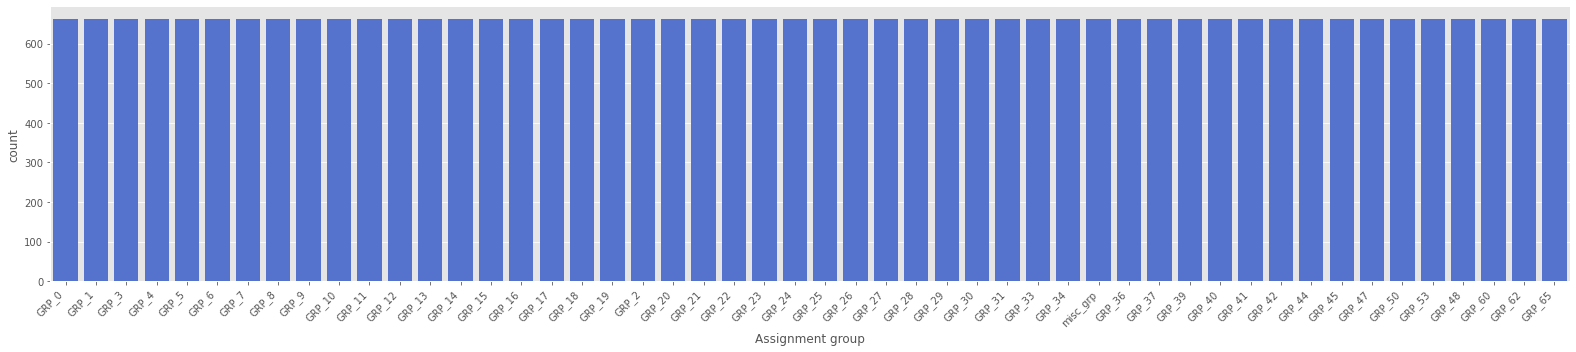

In [56]:
# Treat the imbalnce in the itTicketDF dataset by resampling to 661.This is for us to try creating a single model which use the whiole dataset & verify the performance
itTicketDF_resampled = itTicketDF[0:0]
for grp in itTicketDF['Assignment group'].unique():
    itTicketGrpDF = itTicketDF[itTicketDF['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers), random_state=123)
    itTicketDF_resampled = itTicketDF_resampled.append(resampled)

descending_order = itTicketDF_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [57]:
from sklearn import preprocessing
def labelencoder(dataframe) : 
    label_encoder = preprocessing.LabelEncoder() 
    dataframe= label_encoder.fit_transform(dataframe)
    grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    return dataframe,grp_mapping

#itTicketGRP0DF['Assignment group'] , grp_mapping_grp0= labelencoder(itTicketGRP0DF['Assignment group'])
#itTicketOthersDF_resampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(itTicketOthersDF_resampled['Assignment group'])
otherGrpsResampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(otherGrpsResampled['Assignment group'])
itTicketDF_resampled['Assignment group'] , grp_mapping_all_resampled= labelencoder(itTicketDF_resampled['Assignment group'])
itTicketDF['Assignment group'],grp_mapping_all_raw = labelencoder(itTicketDF['Assignment group'])

<ipython-input-57-8335e3dd49c6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itTicketDF['Assignment group'],grp_mapping_all_raw = labelencoder(itTicketDF['Assignment group'])


In [ ]:
##modelling

In [58]:

from gensim.models import Word2Vec
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,Conv1D,MaxPooling1D
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [60]:
##word to embedding

In [61]:
sentences = [line.split(' ') for line in itTicketDF['Description']]
word2vec = Word2Vec(sentences=sentences,min_count=1)
word2vec.wv.save_word2vec_format('word2vec_vector.txt')

In [62]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('word2vec_vector.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 11244 word vectors.


In [63]:
results=pd.DataFrame()
pred_results = pd.DataFrame()

In [64]:
maxlen = 300
numWords=11439
epochs = 10

In [65]:
class LstmModel:
    model= Model()
    X_test=[]
    y_test=[]
    embedding_matrix=[]
  
    def wordTokenizer(self, dataframe):
        tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
        tokenizer.fit_on_texts(dataframe)
        dataframe = tokenizer.texts_to_sequences(dataframe)
        return tokenizer,dataframe
    
    def splitData(self,X,y):
        print("Number of Samples:", len(X))
        print("Number of Labels: ", len(y))
        X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
        X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
        print("Number of train Samples:", len(X_train))
        print("Number of val Samples:", len(X_Val))
        return X_train, self.X_test, y_train, self.y_test, X_Val, y_Val
  
    def tokenizeAndEmbedding(self,dataframe):
        tokenizer,X = self.wordTokenizer(dataframe['Description'])
        y = np.asarray(dataframe['Assignment group'])
        X = pad_sequences(X, maxlen = maxlen)
        self.embedding_matrix = np.zeros((numWords+1, 100))
        for i,word in tokenizer.index_word.items():
            if i<numWords+1:
                embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
        return X,y
  
    def train(self, dataframe, batch_size, epochs):
        X,y = self.tokenizeAndEmbedding(dataframe)
        X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)
        model_history = self.fitModel(X_train,y_train,X_Val,y_Val,batch_size, epochs)
        return model_history
  
    def fitModel(self,X_train,y_train,X_Val,y_Val,batch_size, epochs):
        input_layer = Input(shape=(maxlen,),dtype=tf.int64)
        embed = Embedding(numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
        lstm=Bidirectional(LSTM(128))(embed)
        drop=Dropout(0.3)(lstm)
        dense =Dense(100,activation='relu')(drop)
        out=Dense(len((pd.Series(y_train)).unique()),activation='softmax')(dense)
        self.model = Model(input_layer,out)
        self.model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
  
        self.model.summary()
        plot_model(self.model,to_file="LSTM_Model.jpg")
  
        checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
        reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
        model_history = self.model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))
        return model_history,self.model
  
    def prediction(self):
        pred = self.model.predict(self.X_test)
        pred = [i.argmax() for i in pred]
        accuracy = metrics.accuracy_score(self.y_test, pred)
        print("Accuracy of the model :",metrics.accuracy_score(self.y_test, pred))
        return accuracy
  
   


In [66]:

# Check how the LSTM Model perform with all the data which is cleansed & resampled to 661 to make the target balance
lstmModelAllDataResampled = LstmModel()
lstmModelAllDataResampled_history, model = lstmModelAllDataResampled.train(itTicketDF_resampled,100,epochs)
resampled_accuracy = lstmModelAllDataResampled.prediction()

Number of Samples: 33050
Number of Labels:  33050
Number of train Samples: 26440
Number of val Samples: 6610
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 100)          1144000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               25700     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
Total param